In [2]:
import bbmaster as mst
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp

### 0. Exciting polarization modes in maps
Producing delta sims with polarization is slightly less trivial than for a scalar field, since setting the temperature - polarization cross to zero actually suppresses the polarized mode. E.g. exciting E therefore requires setting both EE and TE to one, which is fine if we don't care about T.

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


(3, 49152)


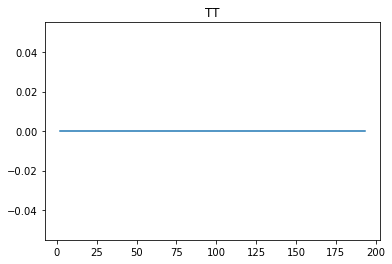

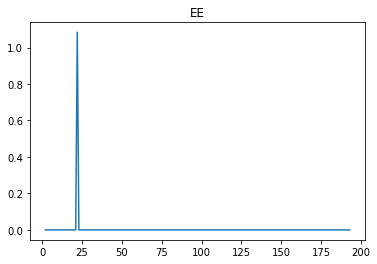

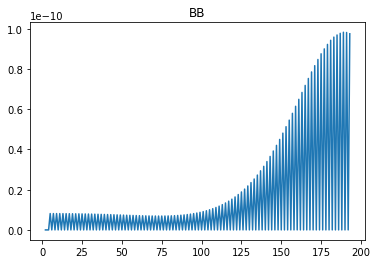

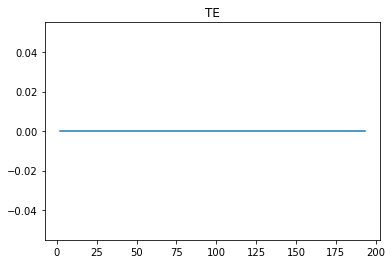

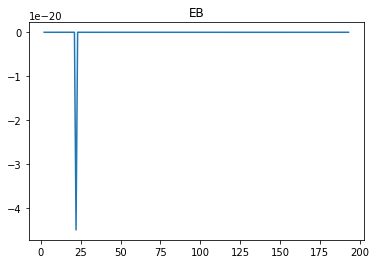

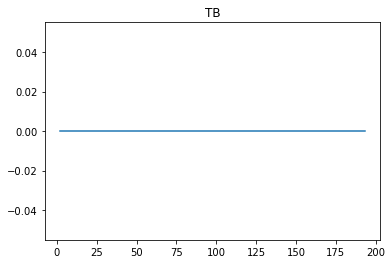

In [3]:
nside = 64
ell = 20
cl_in = np.zeros((6,3*nside)) # TT, EE, BB, TE, EB, TB (New=False)
# for i in [1,2,3,4,5]: # excite EE, BB, EB
#     cl_in[i][ell] = 1
for i in [1,3]: # excite EE
    cl_in[i][ell] = 1
# for i in [2,5]: # excite BB
#     cl_in[i][ell] = 1
map_out = hp.synfast(cl_in, nside, new=False)
print(map_out.shape)
cl_out = hp.anafast(map_out)
for ip, p in enumerate(['TT', 'EE', 'BB', 'TE', 'EB', 'TB']):
    plt.title(p)
    plt.plot(range(2, 2+len(cl_out[ip])), cl_out[ip])
    plt.show()

### 1. Setup
- Read mask.
- Define bandpower bins
- Initialize bandpower window function calculator

In [4]:
# Read mask
nside = 64
#msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
msk = hp.read_map("/global/cscratch1/sd/kwolz/BBPower/examples/data/maps/mask_bin_apo10.0_nside64.fits")
# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
# Bbl calculator
# Dictionary defining method to generate delta sims (not many options yet!)
dsim = {'stats': 'Gaussian'}
# Dictionary defining method to filter (just masking for now)
filt = {'mask': msk}
bc = mst.DeltaBbl(nside, dsim, filt, b, pol=True)

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

In [6]:
# TODO: spin-2 field
f = nmt.NmtField(hp.ud_grade(msk, nside_out=nside), None, spin=2)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)
mcm = w.get_coupling_matrix()
print(mcm.shape)

bpw_true = np.array([b.bin_cell(m) for m in mcm.T]).T

for bpw in bpw_true:
    plt.plot(bpw)
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15);

(768, 768)


ValueError: Input Cl has wrong size

### 3. Compute bandpower windows through simulations

In [ ]:
# TODO: complete cells below (so far just copy & paste)
bpw_num = bc.gen_Bbl_all()

In [ ]:
Now compute them using Gaussian sims

In [ ]:
dsim = {'stats': 'Z2'}
bc_z2 = mst.DeltaBbl(nside, dsim, filt, b)
bpw_num_z2 = bc_z2.gen_Bbl_all()

In [ ]:
for bpw_t, bpw_n, bpw_z2 in zip(bpw_true, bpw_num, bpw_num_z2):
    plt.plot(bc.get_ells(), bpw_n, 'r-')
    plt.plot(bc.get_ells(), bpw_z2, 'y:')
    plt.plot(bpw_t, 'k--')
plt.plot([-1], [0], 'r-', label='Numerical $B_{b\ell}$')
plt.plot([-1], [0], 'y:', label='Numerical $B_{b\ell}\,\,(Z_2)$')
plt.plot([-1], [0], 'k--', label='True $B_{b\ell}$')
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15)
plt.legend(ncol=2, loc='upper center', fontsize=14, frameon=False);